# UNIPD - Deep Learning 2025 - Challenge 1 Template

This is a simple template for the challenge. Feel free to adapt it to your needs.

The following cell contains Kaggle default instruction:

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Linear
import torch.nn.functional as F
from torchvision.datasets import SVHN
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Lambda
import numpy as np
from torchview import draw_graph
from torchinfo import summary
import pandas as pd
import matplotlib.pyplot as plt
import hiddenlayer as hl
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore") #Conflict of nn.functional.act_f and torch.act_f

print("You are using:") # We tested with Python 3.10.12 and torch.__version__='2.2.1+cu121'
!python --version
print(f"{torch.__version__=}")
!nvidia-smi --format=csv --query-gpu=index,name,driver_version,memory.total,memory.used,memory.free

# Set seed for reproducibility
torch.manual_seed(43)
rng = np.random.default_rng(seed=4242)

You are using:
Python 3.13.0torch.__version__='2.7.0+cpu'

index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, NVIDIA GeForce GTX 1060 with Max-Q Design, 561.19, 3072 MiB, 1613 MiB, 1353 MiB


## Data Loading

In [8]:
import os.path as osp
import os
import csv
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, root: str, test: bool = False, transform=None):
        super().__init__()
        self.root = root
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
        ])
        self.test = test

        self.img_path = osp.join(root, 'images')
        self.targets = []
        self.ids = []

        if not test:
            # Load images and labels
            labels_path = osp.join(root, 'labels.csv')
            with open(labels_path, 'r') as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    image_id = row['id'].zfill(5)
                    label = int(row['label'])
                    self.targets.append(label)
                    self.ids.append(image_id)
        else:
            # Test mode: no labels.csv
            for fname in sorted(os.listdir(self.img_path)):
                if fname.endswith('.jpeg'):
                    image_id = fname[:-5].zfill(5)
                    self.ids.append(image_id)

    def __getitem__(self, index: int):
        img_id = self.ids[index]
        img_file = osp.join(self.img_path, f'{img_id}.jpeg')
        img = Image.open(img_file).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)

        if self.test:
            return img, img_id
        else:
            target = self.targets[index]
            return img, target

    def __len__(self) -> int:
        return len(self.ids)

In [9]:
datasets_dir = 'D:/Documents/Uni/UniPD/Year 1/Deep Learning/Challenges/kaggle/input/unipd-deep-learning-2025-challenge-1'

# create datasets
input_dataset = ImageDataset(osp.join(datasets_dir, 'train_dataset'), test=False)
test_dataset = ImageDataset(osp.join(datasets_dir, 'test_dataset'), test=True)

train_size = int(0.8*len(input_dataset))
val_size = len(input_dataset) - train_size

train_dataset, val_dataset = random_split(input_dataset, [train_size, val_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 17944
Val dataset size: 4486
Test dataset size: 4000


In [10]:
img_chan, img_height, img_width = train_dataset[0][0].shape
classes = sorted(np.unique(input_dataset.targets))
num_classes = len(classes)

num_classes

20

In [11]:
print(img_height, img_width)

40 40


In [12]:
from torch.utils.data import DataLoader

# Create data loaders
batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Check the shape of a sample
sample_image, sample_label = next(iter(train_loader))
print(f"Batch image shape: {sample_image.shape}")
print(f"Batch label shape: {sample_label.shape}")

Batch image shape: torch.Size([20, 3, 40, 40])
Batch label shape: torch.Size([20])


In [13]:
import matplotlib.pyplot as plt

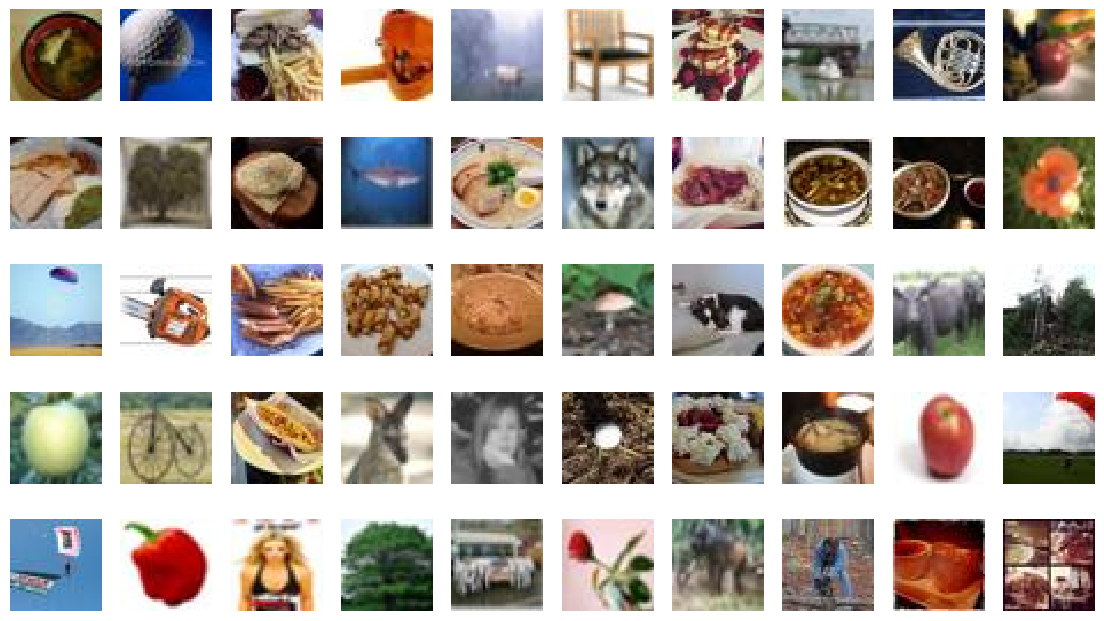

In [14]:

# Plots
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, label = train_dataset[index]
        image = image.permute((1, 2, 0)) #C,H,W -> H,W,C
        plt.imshow(image, cmap="binary", interpolation="nearest")
        plt.axis('off')
plt.show()

## Model Definition

In [15]:
import torch
import torch.nn as nn
from torch.nn import Conv2d, MaxPool2d, Linear
import torch.nn.functional as F
from torchview import draw_graph

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")


device=device(type='cpu')


In [23]:
#Define LeNet5 model

import torch 
import torchsummary
from torchsummary import summary 
import torch.nn as nn 
import torch.nn.functional as F 

class LeNet5(nn.Module): 
	def __init__(self): 
		# Call the parent class's init method 
		super(LeNet5, self).__init__() 
		
		# First Convolutional Layer 
		self.conv1 = nn.Conv2d(3, 6, kernel_size=5) 
		
		# Max Pooling Layer 
		self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
		
		# Second Convolutional Layer 
		self.conv2 = nn.Conv2d(6, 16, kernel_size=5) 
		
		# First Fully Connected Layer 
		self.fc1 = nn.Linear(in_features=16 * 7 * 7, out_features=120) 
		
		# Second Fully Connected Layer 
		self.fc2 = nn.Linear(in_features=120, out_features=84) 
		
		# Output Layer 
		self.fc3 = nn.Linear(in_features=84, out_features=20) 


	def forward(self, x): 
		# Pass the input through the first convolutional layer and activation function 
		x = self.pool(F.relu(self.conv1(x))) 
		
		# Pass the output of the first layer through 
		# the second convolutional layer and activation function 
		x = self.pool(F.relu(self.conv2(x))) 
		
		# Reshape the output to be passed through the fully connected layers 
		x = x.view(-1, 16 *7*7) 
		
		# Pass the output through the first fully connected layer and activation function 
		x = F.relu(self.fc1(x)) 
		
		# Pass the output of the first fully connected layer through 
		# the second fully connected layer and activation function 
		x = F.relu(self.fc2(x)) 
		
		# Pass the output of the second fully connected layer through the output layer 
		x = self.fc3(x) 
		
		# Return the final output 
		return x 
	
	
lenet5_model = LeNet5().to(device)
print(lenet5_model)




LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=20, bias=True)
)


In [24]:
#Define basic hw classifier

import torch
import torch.nn as nn

conv_filters = [10]
kernel_sizes = [[5, 5]]
max_pool_sizes = [[2, 2]]
act_fs = [F.relu]

class ImageClassifier(nn.Module):
  def __init__(self, conv_filters=[], kernel_sizes=[], max_pool_sizes=[], act_fs=[], verbose=False):
    super().__init__()

    assert len(conv_filters) == len(kernel_sizes), "length of {conv_filters} and {kernel_sizes} must be same"
    assert len(conv_filters) == len(max_pool_sizes), "length of {conv_filters} and {max_pool_sizes} must be same"
    # max pool of [1, 1] corresponds to no max pool
    assert len(conv_filters) == len(act_fs), "length of {conv_filters} and {act_fs} must be same"

    self.conv_layers = nn.ModuleList()
    self.max_pools = nn.ModuleList()

    self.in_chan = img_chan
    self.in_height = img_height
    self.in_width = img_width
    
    self.output_dim = num_classes
    self.verbose = verbose
    self.act_fs = act_fs

    height_dimension = self.in_height
    width_dimension = self.in_width

    for maxp1, maxp2 in max_pool_sizes: # as long as padding='same'
      height_dimension = height_dimension // maxp1
      width_dimension = width_dimension // maxp2

    self.inp_dim_to_linear = conv_filters[-1] * height_dimension * width_dimension

    for idx in range(len(conv_filters)):
      if idx == 0:
        # Conv2d(in_channels, out_channels, kernel_size, padding)
        self.conv_layers = self.conv_layers.append(Conv2d(self.in_chan, conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))
      else:
        self.conv_layers = self.conv_layers.append(Conv2d(conv_filters[idx-1], conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))

      self.max_pools = self.max_pools.append(MaxPool2d(max_pool_sizes[idx]))

    self.linear = Linear(self.inp_dim_to_linear, self.output_dim)

    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print(f"My model has {pytorch_total_params} trainable parameters.")

  def forward(self, x):

    for idx in range(len(self.conv_layers)):
      from_shape = x.shape[1:]
      active_conv_layer = self.conv_layers[idx]
      active_max_pool = self.max_pools[idx]
      active_act_fun = self.act_fs[idx]
      x = active_max_pool(active_act_fun(active_conv_layer(x)))
      to_shape = x.shape[1:]

      if self.verbose:
        print(f'From dimension [{from_shape}] to dimension [{to_shape}]')

    x = torch.flatten(x, start_dim=1) # if start_dim=1 missed, it also consider batch_size

    if self.verbose:
        print(f'From dimension [{to_shape}] to dimension [{x.shape[1:]}]')
        print(f'From dimension [{x.shape[1:]}] to dimension [{self.output_dim}]')

    return self.linear(x) # no need to use softmax because of the loss function
  
model = ImageClassifier(conv_filters, kernel_sizes, max_pool_sizes, act_fs, False).to(device)


My model has 80780 trainable parameters.


In [25]:
#Define AlexNet CNN

import torch 
from torchsummary import summary 
import torch.nn as nn 
import torch.nn.functional as F 

class AlexNet(nn.Module): 
	def __init__(self, num_classes=1000): 
		# Call the parent class's init method to initialize the base class 
		super(AlexNet, self).__init__() 
		
		# First Convolutional Layer with 11x11 filters, stride of 4, and 2 padding 
		self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, padding=2) 
		
		# Max Pooling Layer with a kernel size of 3 and stride of 2 
		self.pool = nn.MaxPool2d(kernel_size=3, stride=2) 
		
		# Second Convolutional Layer with 5x5 filters and 2 padding 
		self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2) 
		
		# Third Convolutional Layer with 3x3 filters and 1 padding 
		self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1) 
		
		# Fourth Convolutional Layer with 3x3 filters and 1 padding 
		self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1) 
		
		# Fifth Convolutional Layer with 3x3 filters and 1 padding 
		self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1) 
		
		# First Fully Connected Layer with 4096 output features 
		self.fc1 = nn.Linear(in_features=256*3*3, out_features=4096) 
		
		# Second Fully Connected Layer with 4096 output features 
		self.fc2 = nn.Linear(in_features=4096, out_features=4096) 
		
		# Output Layer with `num_classes` output features 
		self.fc3 = nn.Linear(in_features=4096, out_features=num_classes) 

	def forward(self, x): 
		# Pass the input through the first convolutional layer and ReLU activation function 
		x = self.pool(F.relu(self.conv1(x))) 
		
		# Pass the output of the first layer through 
		# the second convolutional layer and ReLU activation function 
		x = self.pool(F.relu(self.conv2(x))) 
		
		# Pass the output of the second layer through 
		# the third convolutional layer and ReLU activation function 
		x = F.relu(self.conv3(x)) 
		
		# Pass the output of the third layer through 
		# the fourth convolutional layer and ReLU activation function 
		x = F.relu(self.conv4(x)) 
		
		# Pass the output of the fourth layer through 
		# the fifth convolutional layer and ReLU activation function 
		x = self.pool(F.relu(self.conv5(x))) 
		
		# Reshape the output to be passed through the fully connected layers 
		x = x.view(-1, 256*3*3) 
		
		# Pass the output through the first fully connected layer and activation function 
		x = F.relu(self.fc1(x)) 
		x = F.dropout(x, 0.5)	 
		
		# Pass the output of the first fully connected layer through 
		# the second fully connected layer and activation function 
		x = F.relu(self.fc2(x)) 
		
		# Pass the output of the second fully connected layer through the output layer 
		x = self.fc3(x) 
		
		# Return the final output 
		return x 
										
										
AlexNet_model = AlexNet(num_classes=num_classes) 
print(AlexNet_model)


AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2304, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=20, bias=True)
)



(process:37968): Pango-WARNING **: 21:37:28.196: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


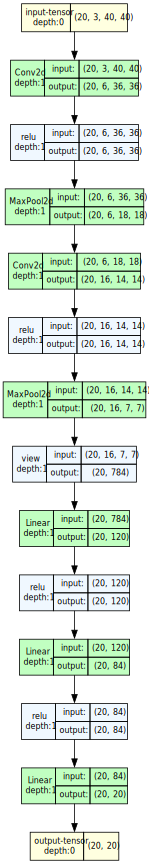

In [26]:
# Let's visualize the model
model_graph = draw_graph(lenet5_model, input_size=(batch_size, 3, 40, 40), device=device)
model_graph.visual_graph

## Training

In [34]:
#Some training parameters, change optmizer if changing model !!

num_epochs = 20
lr = 1e-3
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5_model.parameters(), lr=lr)

In [31]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs, hparam_tuning=False):
  
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  history1 = hl.History() # This is a simple tool for logging
  canvas1 = hl.Canvas() # This is a simple tool for plotting
  
  base_transform = transforms.Compose([
        transforms.ToTensor(), # add a normalization later ?
    ])
  aug_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.333),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(), #Add a normalization later?
    ])
  
  
  for epoch in range(epochs):

    current_transform = base_transform if epoch == 0 else aug_transform

    train_dataset = ImageDataset(osp.join(datasets_dir, 'train_dataset'), transform = current_transform, test = False)
    dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (img, label) in enumerate(dataloader_train):
      img, label = img.to(device), label.to(device)
      optimizer.zero_grad()
      logits = model(img)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (img, label) in enumerate(dataloader_val):
            img, label = img.to(device), label.to(device)
            logits = model(img)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      if not hparam_tuning:
        history1.log(epoch, train_loss=avg_loss_train, train_accuracy=accuracy_train,
                     val_loss=avg_loss_val, val_accuracy=accuracy_val)

        with canvas1:
          canvas1.draw_plot([history1["train_loss"], history1["val_loss"]])
          canvas1.draw_plot([history1["train_accuracy"], history1["val_accuracy"]])
      else:
        print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
        print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):
    # Helper function to plot again accuracy and loss

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(len(acc_tr)), acc_tr, label='acc_training')
    plt.plot(range(len(acc_tr)), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(len(acc_tr)), loss_tr, label='loss_training')
    plt.plot(range(len(acc_tr)), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()
    raise NotImplementedError

In [35]:
# train the Lenet5 Model

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(lenet5_model, optimizer, train_loader, val_loader, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

KeyboardInterrupt: 

In [32]:
#Train AlexNet

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(AlexNet_model, optimizer, train_loader, val_loader, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

KeyboardInterrupt: 

## Test Predictions

In [ ]:
results = []

for images, img_ids in test_loader:
    preds = model(images)
    predicted_labels = preds.argmax(dim=1).item()
    results.extend(zip(img_ids, predicted_labels))

In [ ]:
import pandas as pd

submission_df = pd.DataFrame(results, columns=['id', 'label'])
submission_df.to_csv('submission.csv', index=False)